**Business Context**

1. The approval process for civil service examinations in Brazil increasingly demands a focused, balanced, and directed preparation. We, from Qconcursos, frequently seek to evolve our product in order to ease this learning process. In this sense, we seek to rely on the best educational methods and the best technological practices.

2. We are convinced that the concept of adaptive learning presents itself as a possible solution to help test takers in their learning methodology and, consequently, in their search for the dream public career. In general, the idea is to adapt the teaching and mold it to the needs and learning pace of each student within our platform.

3. The goal of this competition is to create a machine learning model capable of predicting the probability of a given student getting the next question right, given a previous sequence of one hundred resolutions.

<hr>

**QConcursos Test**

DataSet

For this challenge we have made available two data sets that, put together, concentrate qualitative information about the users, information about the questions and about the performance in each resolution. It should also be noted that the data was anonymized so that it is impossible to identify any person in the example.

The Challenge

Participants are requested to create a model to rank the answer to the 101st question, given a set of 100 answers to questions answered sequentially by 20,000 users.

The Dataset_Model database contains the answers to 100 questions answered sequentially by 20,000 users and should be used to train the model.

The subjects_question file contains additional information about the questions, mapping the questions to subjects. It's important to note that each question may contain more than one subjects.

The file Submit.csv is the file that contains the data about the 101st question for each user. Your model should score the "Acertou" (in english "got it right") column, containing "0" for wrong or "1" for correct.

You must submit a .csv file containing 20,000 rows and only one column containing the 0's and 1's that your model calculated.

Evaluation method

For this classification challenge we will adopt the "F1-Score" as the evaluation method. This metric can be interpreted as a weighting between "precision" and "recall", as shown in the formula below.

<hr>

In [1]:
import numpy as np
import pandas as pd

from warnings import filterwarnings

import seaborn as sns
from matplotlib import pyplot as plt

from scipy.stats import chi2_contingency

from category_encoders import TargetEncoder
from sklearn.preprocessing import MinMaxScaler, RobustScaler

filterwarnings('ignore')

#### 0.1. Aux Funcs

In [2]:
def get_os_versions(os_split):
    # this func receive a list 
    # need to be a list os lists splited by '.' 
    # of all version os number
    
    vers = []
    for r in os_split:
        if len(r) > 1:
            ver = r[0]+'.'+r[1]
            ver = float(ver)
        else:
            try:
                ver = float(r[0])
            except:
                ver = 1.0

        vers.append(ver)

    return vers


def plot_hists(df4, num_atts, y, clrs):
    ans = df4[y].value_counts().to_dict()
    fig, ax = plt.subplots(6, 3, figsize=(10,9))
    ax = ax.flatten()
    for col, axi in zip(num_atts.columns, ax):
        for a, c in zip(df4[y].unique(), clrs):
            aux = df4[df4[y] == a]
            axi.hist(aux[col], bins=50, color=c, label=a)
        axi.set_title(f'Hist for {col.capitalize()}')

        ax[-1].bar(ans.keys(), ans.values(), color=clrs)
        
    plt.tight_layout();

    return ax


def spyder_plot(cat_atts):
    categories=list(cat_atts.iloc[:,:-1])
    N = len(categories)

    # 360 Radius angle +1 for complete circle
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    # Polar angles
    ax = plt.subplot(111, polar=True)
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(1)
    ax.set_rlabel_position(0)

    # Set ax_ticks
    plt.xticks(angles[:-1], categories)
    plt.yticks([10,20,30], ["10","20","30"], color="k", size=7);
    
    #for user in grouped_users
        # Add users spyder categoryes here 

    return ax

def cramer_v( x, y ):
        cm = pd.crosstab( x, y ).values

        chi2 = chi2_contingency( cm )[0]
        n    = cm.sum()
        r, k = cm.shape

        chi2corr = max( 0, chi2 - (r-1)*(k-1)/(n-1) )
        kcorr = k - (k-1)**2 / (n-1)
        rcorr = r - (r-1)**2 / (n-1)

        return np.sqrt( (chi2corr/n) / min(kcorr-1, rcorr-1) )

def get_cramer_cors(cat_atts, full_df):
    data_cors = {}
    for i in cat_atts.columns:
        corrs = []
        for j in cat_atts.columns:
            corr = cramer_v(full_df[i], full_df[j])
            corrs.append(corr)
        
        data_cors[i] = corrs

    return data_cors




d = {
 'novo_user_id': 'int32',
 'city': 'O',
 'country': 'O',
 'device': 'O',
 'device_type': 'O',
 'os': 'O',
 'platform': 'O',
 'region': 'O',
 'gp:carrers': 'O',
 'gp:college type': 'O',
 'gp:degree course': 'O',
 'gp:previous experience': 'O',
 'gp:school type': 'O',
 'gp:segment': 'O',
 'gp:source_project': 'O',
 'acertou': 'int32',
 'created_at': 'O',
 'row': 'int32',
 'commented_by_professor': 'float32',
 'difficulty': 'float32',
 'discipline_id': 'float32',
 'examining_board_id': 'float32',
 'institute_id': 'float32',
 'knowledge_area_id': 'float32',
 'modality_id': 'float32',
 'nullified': 'float32',
 'outdated': 'float32',
 'product_id': 'float32',
 'publication_year': 'float32',
 'right_answer': 'O',
 'scholarity_id': 'float32',
 'novo_question_id': 'int32'
}

#### 0.2. Data Load

In [3]:
df_raw = pd.read_csv('../data/Dataset_model.csv', dtype=d)

# Simple Filtering
df_raw = df_raw[df_raw.right_answer.isin(['A', 'B', 'C', 'D', 'E'])].reset_index(drop=True)

In [4]:
users_filter = df_raw[['novo_user_id', 'right_answer']].groupby('novo_user_id').count().reset_index().query('right_answer >= 100')

df_raw = df_raw[df_raw.novo_user_id.isin(users_filter['novo_user_id'].tolist())]

## 1.0. Descriptive Statistical

In [ ]:
df_raw.to_feather('../data/backup_descriptive_stats.f')

In [17]:
df_raw = df_raw.reset_index(drop=True)

In [19]:
df_raw.novo_user_id.unique() # Missing Users

array([    1,     2,     4, ..., 19996, 19997, 19998], dtype=int32)

### 1.1. Rename Columns

In [4]:
cols = [c.replace('gc', '').replace(':', '').replace(' ', '_').replace('gp', '') for c in df_raw.columns.tolist()]
df_raw.columns = cols

### 1.2. Data Dimension

In [5]:
print(f'Number of Cols: {df_raw.shape[1]}')
print(f'Number of Rows: {df_raw.shape[0]}')

Number of Cols: 32
Number of Rows: 1987900


### 1.3. Check NaN

In [6]:
print(df_raw.isna().sum() / len(df_raw), file=open('outs.txt', 'a'))

### 1.4. Fillout NaN

In [7]:
# More than 80% nulls
cols_drop = ['college_type', 'degree_course', 'previous_experience', 'school_type']

df_raw = df_raw.drop(columns=cols_drop, axis=1)

df = df_raw.dropna()

users_filter = df[['novo_user_id', 'right_answer']].groupby('novo_user_id').count().reset_index().query('right_answer >= 100')

df_raw = df[df.novo_user_id.isin(users_filter['novo_user_id'])]

### 1.5. Change Data Types

In [8]:
df_raw['created_at'] = pd.to_datetime(df_raw['created_at'], format='%Y-%m-%d %H:%M:%S')

for k in ['modality_id', 'nullified', 'outdated', 'product_id', 'scholarity_id', 'commented_by_professor', 'acertou']:
    df_raw[k] = df_raw[k].astype('uint8')

### 1.6. Statistics Description

#### 1.6.1. Numerical Attributes

In [9]:
df_raw.select_dtypes(include=['uint8', 'float32', 'int32']).describe().T.iloc[1:, :]

,count,mean,std,min,25%,50%,75%,max
acertou,1541000.0,0.656970,0.474722,0.0,0.00,1.0,1.00,1.0
row,1541000.0,50.500000,28.866079,1.0,25.75,50.5,75.25,100.0
commented_by_professor,1541000.0,0.556859,0.496757,0.0,0.00,1.0,1.00,1.0
difficulty,1541000.0,1.999751,0.854212,1.0,1.00,2.0,3.00,5.0
discipline_id,1541000.0,71.737473,137.498291,1.0,2.00,9.0,53.00,593.0
examining_board_id,1541000.0,176.466064,326.436096,1.0,2.00,63.0,207.00,3771.0
institute_id,1541000.0,4496.507812,2916.397217,1.0,291.00,5778.0,6256.00,10265.0
knowledge_area_id,1541000.0,15.786953,30.424200,1.0,9.00,9.0,14.00,325.0
modality_id,1541000.0,1.248385,0.432076,1.0,1.00,1.0,1.00,2.0
nullified,1541000.0,0.002569,0.050621,0.0,0.00,0.0,0.00,1.0


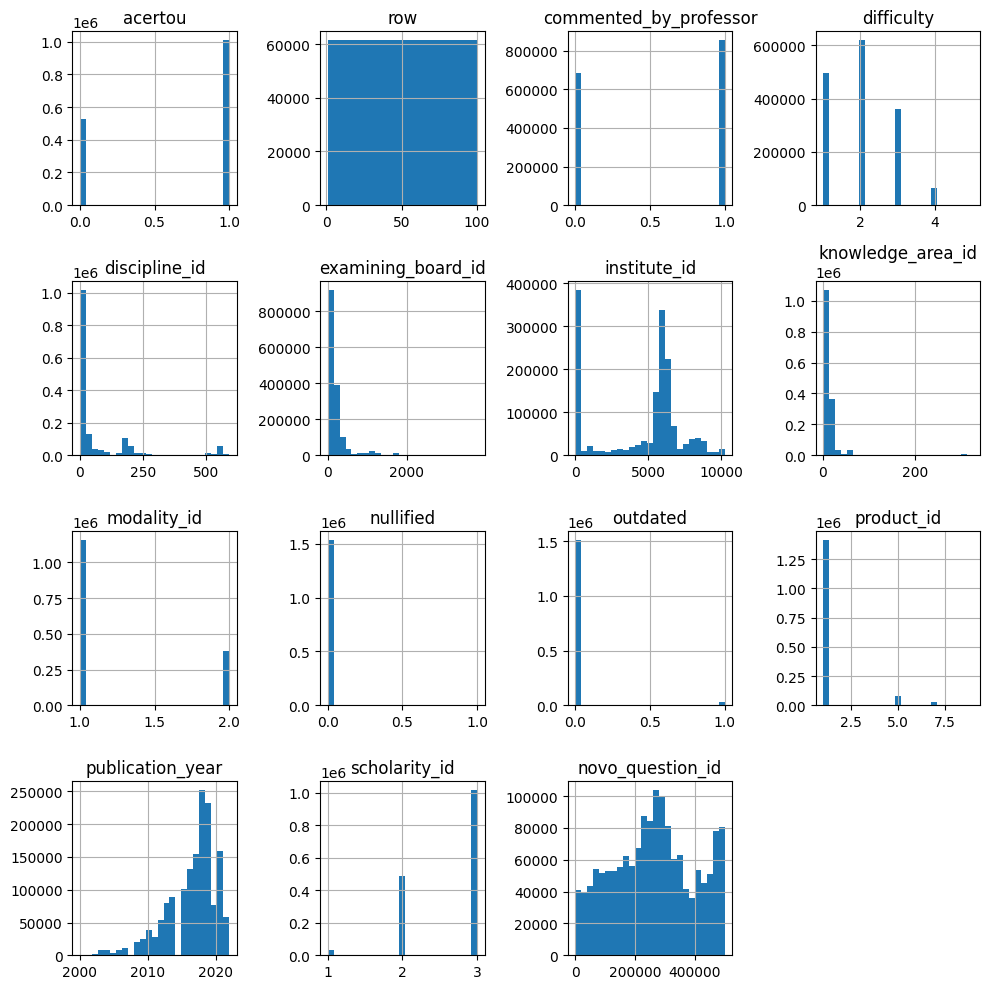

In [10]:
df_raw.select_dtypes(include=['uint8', 'float32', 'int32']).iloc[:, 1:].hist(bins=25, figsize=(10,10));
plt.tight_layout()

#### 1.6.2. Categorical Attributes

In [13]:
df_raw.select_dtypes(exclude=['uint8', 'float32', 'int32', 'datetime64[ns]']).describe()

,city,country,device,device_type,os,platform,region,carrers,segment,source_project,right_answer
count,1541000,1541000,1541000,1541000,1541000,1541000,1541000,1541000,1541000,1541000,1541000
unique,1658,12,33,353,193,3,41,1278,4,2,5
top,Brasília,Brazil,Windows,Windows,Chrome 103,Web,Sao Paulo,Policial,Concurso Público,odin,C
freq,145900,1539200,1027300,1027300,409700,1310300,195900,382900,1485900,1353600,440512


In [28]:
df_raw.novo_user_id.unique()

array([    1,     2,     4, ..., 19996, 19997, 19998], dtype=int32)

## 2.0. Feature Engineering

In [3]:
df2 = pd.read_feather('../data/backup_descriptive_stats.f')

### 2.1. Mind Map Hypothesis

### 2.2. Hypothesis List

In [ ]:
# Country Per Users (Checkout Users interaction based on other country!)

### 2.3. Feature Engineering

In [4]:
os_split = [k.split(' ') for k in df2.os.tolist()]
df2['os'] = [row[0].upper().strip() for row in os_split]

os_split = [row[1].split('.') for row in os_split]
vers = get_os_versions(os_split)
df2['os_ver'] = vers

df2.os_ver = df2.os_ver.astype('float32')

In [8]:
df2['created_day'] = df2.created_at.dt.day

df2['created_month'] = df2.created_at.dt.month

df2['created_year'] = df2.created_at.dt.year

df2['created_hour'] = df2.created_at.dt.hour

df2['created_minute'] = df2.created_at.dt.minute

In [13]:
df2.to_feather('../data/feature_creation.f')

## 3.0. Data Filtering

1. Data Filtering on Load for memory saving
2. Need to fill na to do not lose users id's

## 4.0. Exploratory Data Analisys

In [9]:
df4 = pd.read_feather('../data/feature_creation.f')
ans = df4.right_answer.unique()

In [10]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1541000 entries, 0 to 1540999
Data columns (total 29 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   novo_user_id            1541000 non-null  int32         
 1   city                    1541000 non-null  object        
 2   country                 1541000 non-null  object        
 3   device                  1541000 non-null  object        
 4   device_type             1541000 non-null  object        
 5   os                      1541000 non-null  object        
 6   platform                1541000 non-null  object        
 7   region                  1541000 non-null  object        
 8   carrers                 1541000 non-null  object        
 9   segment                 1541000 non-null  object        
 10  source_project          1541000 non-null  object        
 11  acertou                 1541000 non-null  uint8         
 12  created_at    

### 4.1. Univariable Analysis

#### 4.1.1. Response Variable

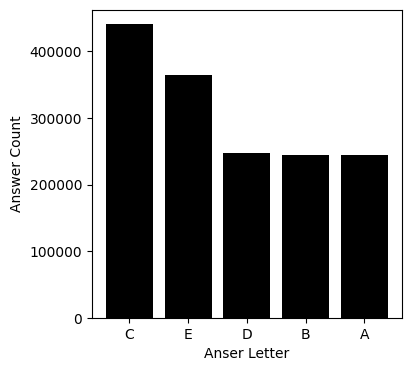

In [11]:
ans = df4.right_answer.value_counts().to_dict()

fig, ax = plt.subplots(figsize=(4,4))
ax.bar(ans.keys(), ans.values(), color='k');
ax.set_ylabel('Answer Count');
ax.set_xlabel('Anser Letter');

In [12]:
pd.DataFrame(ans, index=[0]).T[0] / len(df4)

C    0.285861
E    0.236770
D    0.160217
B    0.158794
A    0.158358
Name: 0, dtype: float64

#### 4.1.2. Numerical Features

In [13]:
num_atts = df4.select_dtypes(exclude=['object', 'datetime64[ns]']).iloc[:,1:]
num_atts = num_atts.drop(columns=['row'])

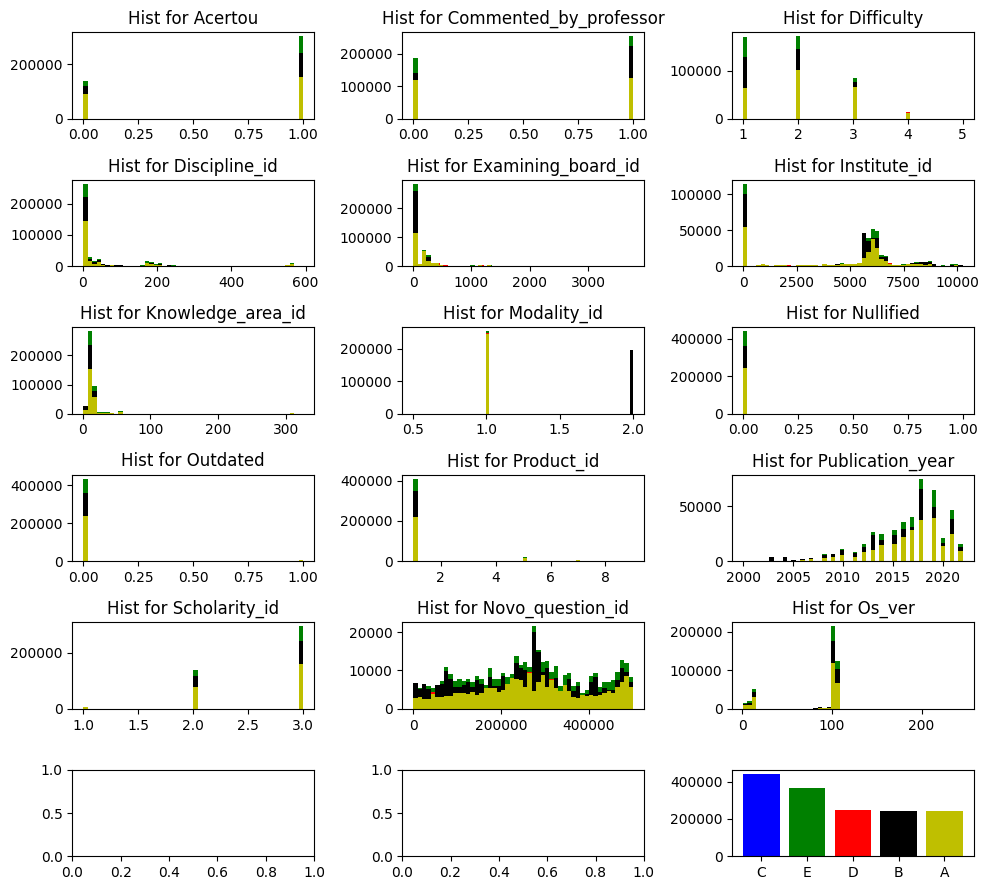

In [16]:
clrs = ['b', 'g', 'r', 'k', 'y']
plot_hists(df4, num_atts, 'right_answer', clrs);

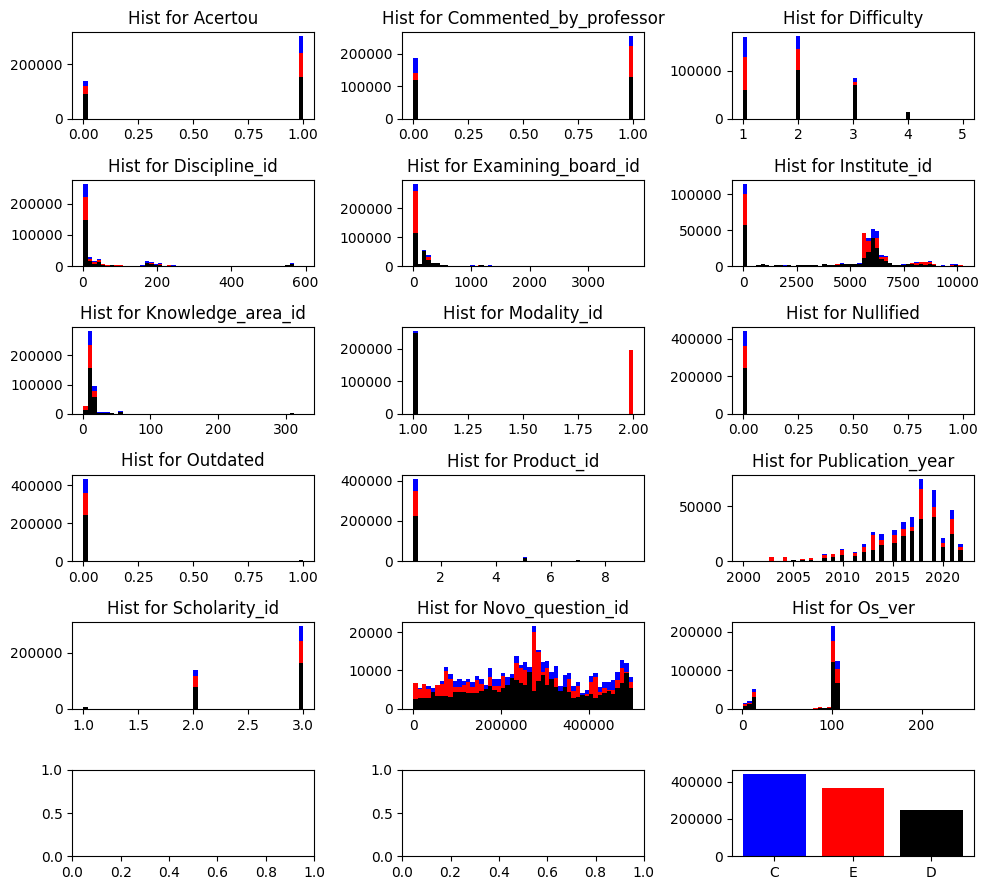

In [18]:
clrs = ['b', 'r', 'k']
fig, ax = plt.subplots(6, 3, figsize=(10,9))
ax = ax.flatten()
for col, axi in zip(num_atts.columns, ax):
    for a, c in zip(list(ans.keys())[:3], clrs):
        aux = df4[df4['right_answer'] == a]
        axi.hist(aux[col], bins=50, color=c, label=a)
    axi.set_title(f'Hist for {col.capitalize()}')

    ax[-1].bar(list(ans.keys())[:3], list(ans.values())[:3], color=clrs)
    
plt.tight_layout();

#### 4.1.3. Categorical Features 

In [19]:
cat_atts = df4.select_dtypes(include=['object'])

In [20]:
cat_atts.describe()

,city,country,device,device_type,os,platform,region,carrers,segment,source_project,right_answer
count,1541000,1541000,1541000,1541000,1541000,1541000,1541000,1541000,1541000,1541000,1541000
unique,1658,12,33,353,15,3,41,1278,4,2,5
top,Brasília,Brazil,Windows,Windows,CHROME,Web,Sao Paulo,Policial,Concurso Público,odin,C
freq,145900,1539200,1027300,1027300,1066200,1310300,195900,382900,1485900,1353600,440512


In [22]:
aux = cat_atts[['country', 'platform', 'segment', 'source_project', 'os']]

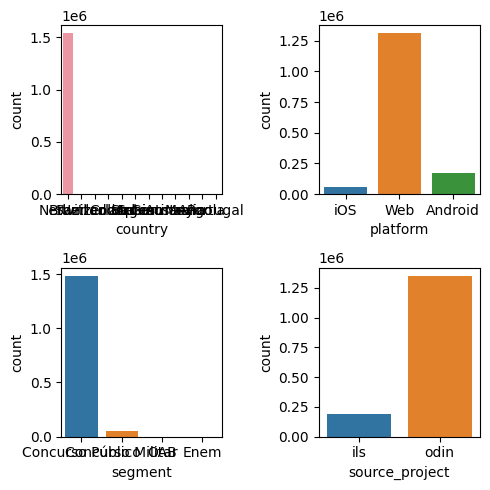

In [25]:
fig, ax = plt.subplots(2, 2, figsize=(5,5))
for axi, i in zip(ax.flatten(), range(0, aux.shape[0])):
    sns.countplot(x=aux.iloc[:,i], ax=axi)
plt.tight_layout()

### 4.2. Bivariable Analysis

### 4.3. Multivariable Analysis

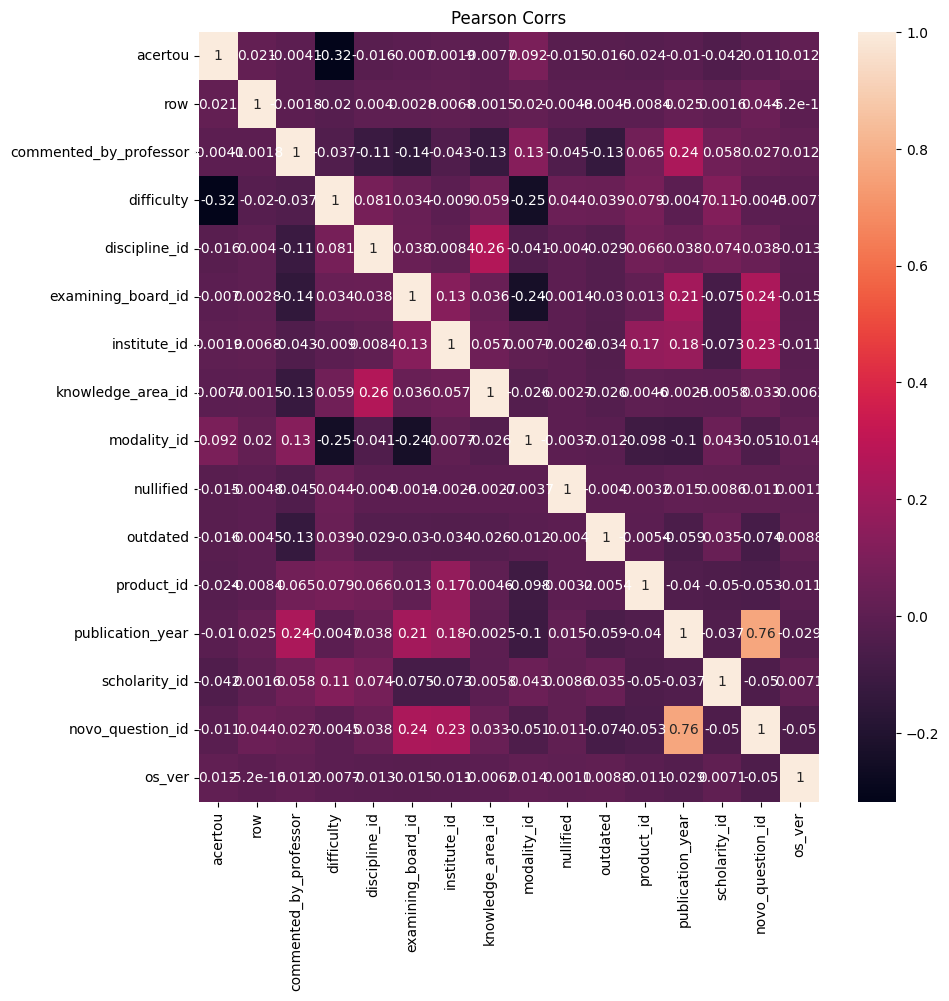

In [26]:
_, _ = plt.subplots(figsize=(10,10))
ax = sns.heatmap(df4.iloc[:,1:].corr(method='pearson'), annot=True);
ax.set_title('Pearson Corrs');

In [27]:
cat_atts = df4.select_dtypes(include=['object'])

data_cors = get_cramer_cors(cat_atts, df4)

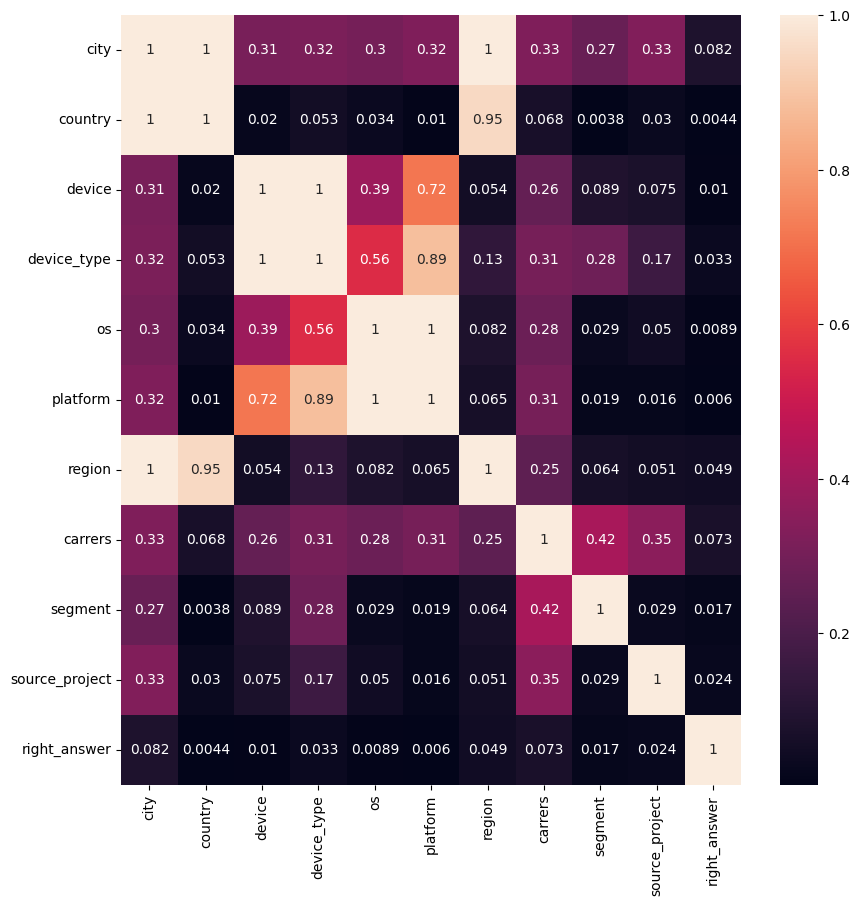

In [28]:
cdf = pd.DataFrame(data_cors)
cdf = cdf.set_index(cdf.columns)

_, _ = plt.subplots(figsize=(10,10))
sns.heatmap(cdf, annot=True);

In [5]:
c_ans = df4[df4.right_answer == 'C']
num_atts = c_ans.select_dtypes(exclude=['object', 'datetime64[ns]'])

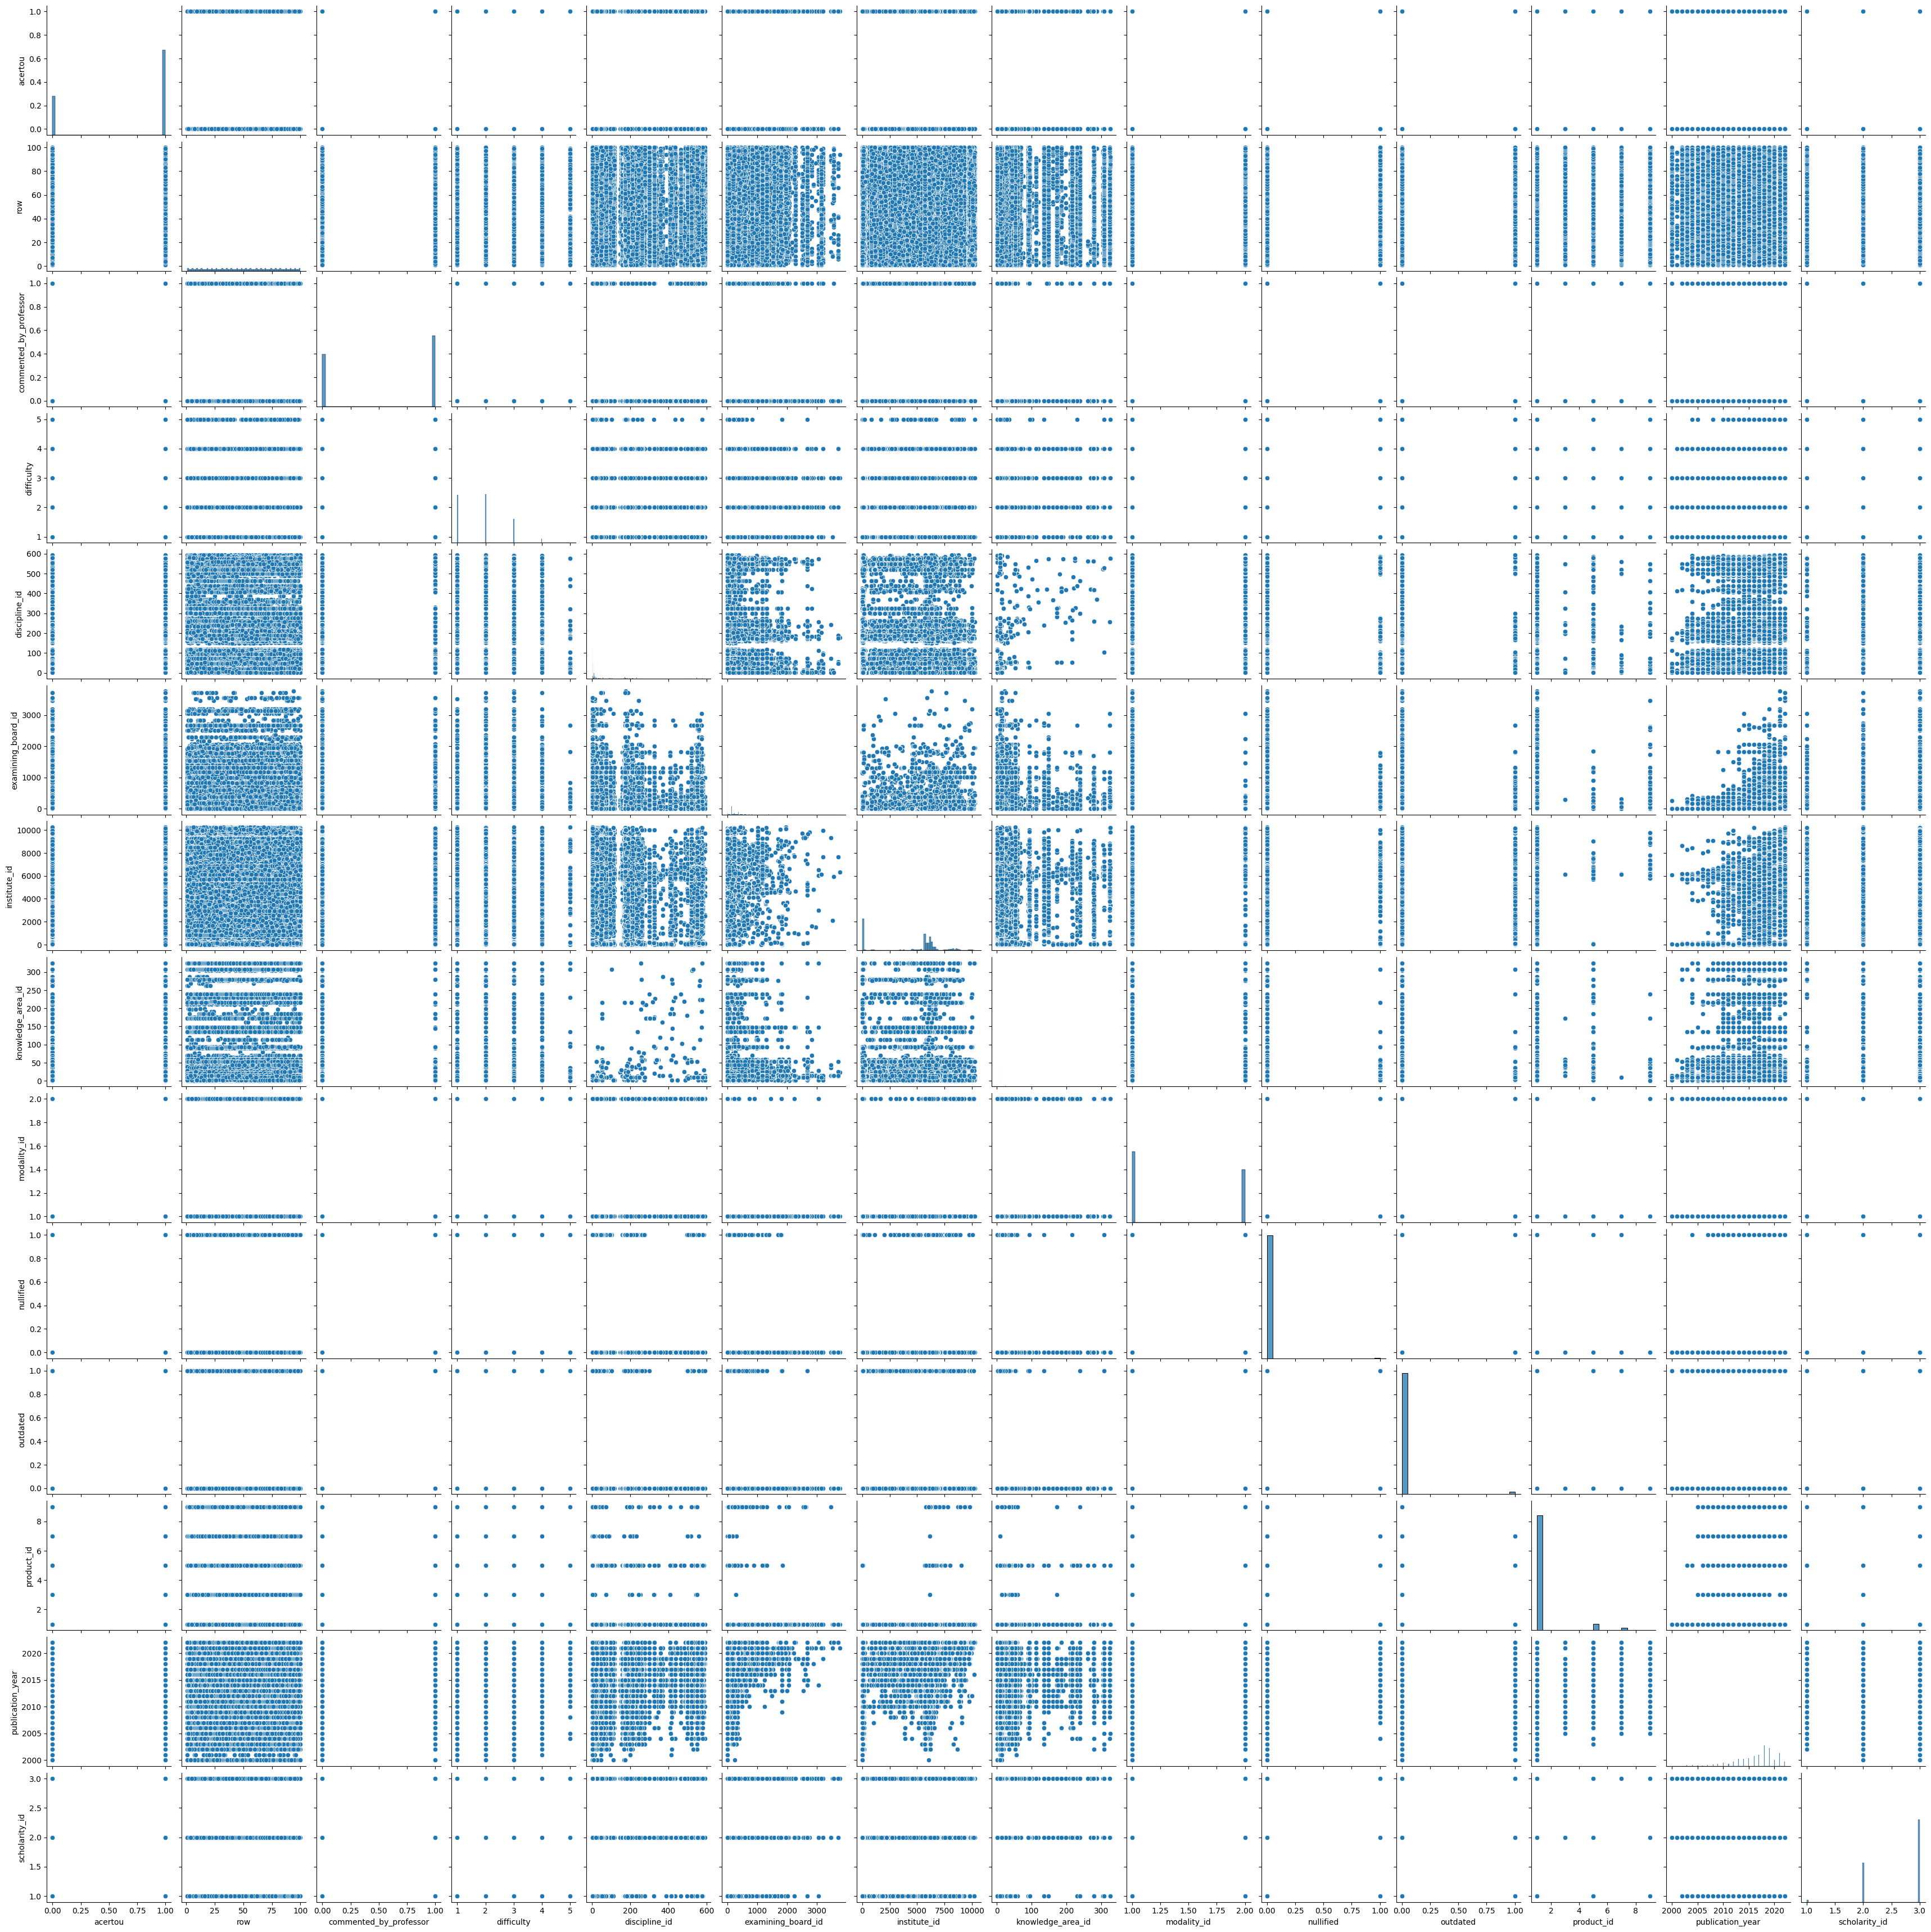

In [7]:
sns.pairplot(num_atts.iloc[:,1:-1])

## 5.0. Data Preparation

In [14]:
df5 = pd.read_feather('../data/feature_creation.f')

### 5.1. Split Into Train and Test

Select last user question answer for testing.

In [15]:
df_test = pd.DataFrame(columns=df5.columns, index=[0])

for user_range in list(range(0, len(df5)+100, 100)):
    df_test = pd.concat([df_test, df5.iloc[user_range-1:user_range, :]], axis=0)

df_test = df_test.iloc[1:, :]

df_test = df_test.reset_index(drop=True)

In [16]:
print(f"Last User Question Datetime: {df_test.iloc[0]['created_at']}")
print(f"Last User 1 Question Datetime: {df5[df5.novo_user_id == 1].created_at.max()}")

Last User Question Datetime: 2022-03-23 21:44:35
Last User 1 Question Datetime: 2022-03-23 21:44:35


In [17]:
df5 = df5.drop(df_test.index).reset_index(drop=True)

In [19]:
df5 = df5[
        ['novo_user_id', 'city', 'country', 'device', 'device_type', 'os',
         'platform', 'region', 'carrers', 'segment', 'source_project', 'acertou',
         'created_at', 'row', 'commented_by_professor', 'difficulty',
         'discipline_id', 'examining_board_id', 'institute_id',
         'knowledge_area_id', 'modality_id', 'nullified', 'outdated',
         'product_id', 'publication_year', 'scholarity_id',
         'novo_question_id', 'os_ver', 'created_day', 'created_month',
         'created_year', 'created_hour', 'created_minute', 'right_answer']
]

In [21]:
df_test.to_feather('../data/test_data.f')
df5.to_feather('../data/train_data.f')

### 5.2. Data Preparation

In [9]:
df5 = pd.read_feather('../data/train_data.f')

# Filtering Columns
# Carrers need to filter too
cols = ['device_type', 'device', 'city', 'region', 'source_project', 'novo_question_id']

df5 = df5.drop(columns=cols)

#### 5.2.1. Normalization

In [11]:
# None

#### 5.2.2. Rescaling

In [10]:
mms = MinMaxScaler()
rs = RobustScaler()

### MinMax
df5['row'] = mms.fit_transform(df5[['row']].values)
df5['institute_id'] = mms.fit_transform(df5[['institute_id']].values)
df5['publication_year'] = mms.fit_transform(df5[['publication_year']].values)

### Robust
df5['os_ver'] = rs.fit_transform(df5[['os_ver']].values)
df5['discipline_id'] = rs.fit_transform(df5[['discipline_id']].values)
df5['knowledge_area_id'] = rs.fit_transform(df5[['knowledge_area_id']].values)
df5['examining_board_id'] = rs.fit_transform(df5[['examining_board_id']].values)

#### 5.2.3. Encoding

In [11]:
# Label
df5.right_answer = df5.right_answer.map({'A':0, 'C':2, 'E':4, 'D':3, 'B':1})
df5.segment = df5.segment.map({'Enem': 0, 'Concurso Público': 1, 'Concurso Militar': 2, 'OAB': 3})

# OHE
df5 = pd.concat([df5, pd.get_dummies(df5['platform'])], axis=1)
df5 = df5.drop(columns=['platform'])

# Target
tar = TargetEncoder()
df5['os'] = tar.fit_transform(df5[['os']].values, df5['right_answer'])
df5['country'] = tar.fit_transform(df5[['country']].values, df5['right_answer'])
df5['carrers'] = tar.fit_transform(df5[['carrers']].values, df5['right_answer'])

#### 5.2.4. Nature

In [14]:
df5.created_at

0         2010-04-08 12:25:56
1         2010-04-08 13:14:01
2         2010-04-08 13:17:05
3         2010-04-08 13:48:06
4         2010-04-08 14:08:44
                  ...        
1525585   2022-08-12 21:51:05
1525586   2022-08-12 21:51:31
1525587   2022-08-12 21:52:21
1525588   2022-08-12 21:52:51
1525589   2022-08-12 21:53:33
Name: created_at, Length: 1525590, dtype: datetime64[ns]